# Table of Contents

- [Preprocessing for Clustering](#preprocessing-for-clustering)
  - [Merging DataFrames](#merging-dataframes)
  - [Feature selection](#feature-selection)
  - [Pairplots, correlation matrix and analysis](#pairplots,-correlation-matrix-and-analysis)
  - [Scaling](#scaling)
- [K-means Clustering](#k-means-clustering)
- [DBSCAN Clustering](#dbscan-clustering)
- [Hierarchical Clustering](#hierarchical-clustering)
- [Cluster Evaluation and Interpretation](#cluster-evaluation-and-interpretation)
- [Final observations](#final-observations)


# Preprocessing for Clustering

Constants:

In [10]:
# How many samples to take for each test
SAMPLE_SIZE = 5000

In [11]:
import pandas as pd
import numpy as np
import seaborn as sns

# Autoreload allows the notebook to dynamically load code: if we update some helper functions outside of the notebook, we do not need to reload the notebook.
%load_ext autoreload
%autoreload 2

# All auxiliary code is in ../src
# code taken from: https://github.com/data-mining-UniPI/teaching24/tree/main/src
import sys
sys.path.append("./src/")

# Set style for seaborn
sns.set_theme(style="darkgrid")

# Other available themes:
# sns.set_theme(style="whitegrid")
# sns.set_theme(style="dark")
# sns.set_theme(style="white")
# sns.set_theme(style="ticks")

# Load datasets
cyclists_df = pd.read_pickle('cyclists_transformed.pkl')
races_df = pd.read_pickle('races_transformed.pkl')

# Display info
print("Cyclists DataFrame:")
print(cyclists_df.info())
print("\nRaces DataFrame:")
print(races_df.info())

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Cyclists DataFrame:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6134 entries, 0 to 6133
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   _url                6134 non-null   string 
 1   name                6134 non-null   string 
 2   birth_year          6134 non-null   int64  
 3   weight              6134 non-null   float64
 4   height              6134 non-null   float64
 5   nationality         6134 non-null   string 
 6   BMI                 3071 non-null   float64
 7   races_participated  6134 non-null   float64
 8   _url_cyclist        6095 non-null   string 
 9   average_delta       6134 non-null   float64
dtypes: float64(5), int64(1), string(4)
memory usage: 479.3 KB
None

Races DataFrame:
<class 'pandas.core.frame.DataFrame'>
Index: 589618 entries, 0 to 589864
Data columns (total 16 columns):
 #   

## Merging DataFrames

In [12]:
merged_df = pd.merge(races_df, cyclists_df, left_on='cyclist', right_on='_url')
merged_df.head()

,_url_x,name_x,points,length,climb_total,profile,startlist_quality,position,cyclist,cyclist_age,...,_url_y,name_y,birth_year,weight,height,nationality,BMI,races_participated,_url_cyclist,average_delta
0,tour-de-france/1978/stage-6,Tour de France,100,162000,1101,1,1241,0,sean-kelly,22,...,sean-kelly,Sean Kelly,1956,77.0,180.0,Ireland,23.8,322.5,sean-kelly,151.0
1,tour-de-france/1978/stage-6,Tour de France,100,162000,1101,1,1241,1,gerrie-knetemann,27,...,gerrie-knetemann,Gerrie Knetemann,1951,65.0,177.0,Netherlands,NaN,271.0,gerrie-knetemann,284.0
2,tour-de-france/1978/stage-6,Tour de France,100,162000,1101,1,1241,2,rene-bittinger,24,...,rene-bittinger,René Bittinger,1954,69.0,174.0,France,22.8,146.0,rene-bittinger,239.0
3,tour-de-france/1978/stage-6,Tour de France,100,162000,1101,1,1241,3,joseph-bruyere,30,...,joseph-bruyere,Joseph Bruyère,1948,72.0,178.0,Belgium,NaN,48.0,joseph-bruyere,100.0
4,tour-de-france/1978/stage-6,Tour de France,100,162000,1101,1,1241,4,sven-ake-nilsson,27,...,sven-ake-nilsson,Sven-Åke Nilsson,1951,63.0,172.0,Sweden,21.3,145.0,sven-ake-nilsson,129.0


In [13]:
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 589618 entries, 0 to 589617
Data columns (total 26 columns):
 #   Column              Non-Null Count   Dtype         
---  ------              --------------   -----         
 0   _url_x              589618 non-null  string        
 1   name_x              589618 non-null  string        
 2   points              589141 non-null  Int64         
 3   length              589618 non-null  Int64         
 4   climb_total         442616 non-null  Int64         
 5   profile             441606 non-null  Int64         
 6   startlist_quality   589618 non-null  int64         
 7   position            589618 non-null  int64         
 8   cyclist             589618 non-null  string        
 9   cyclist_age         589618 non-null  Int64         
 10  cyclist_team        430594 non-null  string        
 11  delta               589618 non-null  Int64         
 12  year                589618 non-null  int32         
 13  race_day            589618 no

## Feature selection

In [14]:
# Select features from cyclists_df

cyclists_features_list = ['weight', 'races_participated', 'average_delta'] # TODO: deciderle bene
races_features_list = ['climb_total', 'startlist_quality', 'delta']

cyclists_features = cyclists_df[cyclists_features_list]
races_features = races_df[races_features_list]
merged_features = merged_df[cyclists_features_list + races_features_list]

# Drop rows with missing values
cyclists_features = cyclists_features.dropna() # TODO: dovrebbero essere 0. verificare, e poi rimuovere questa riga.
races_features = races_features.dropna()
merged_features = merged_features.dropna()

## Sampling

In [15]:
# Perform sampling
cyclists_features = cyclists_features.sample(n=SAMPLE_SIZE, random_state=42)
races_features = races_features.sample(n=SAMPLE_SIZE, random_state=42)
merged_features = merged_features.sample(n=SAMPLE_SIZE, random_state=42)

## Pairplots, correlation matrix and analysis

In [16]:
# Plot the pairplots
# sns.pairplot(cyclists_features)
# sns.pairplot(races_features)
# sns.pairplot(merged_features)

## Scaling

In [17]:
from sklearn.preprocessing import StandardScaler

# Initialize the scaler
scaler = StandardScaler()

# Scale the dataframes
cyclists_scaled = scaler.fit_transform(cyclists_features)
races_scaled = scaler.fit_transform(races_features)
merged_scaled = scaler.fit_transform(merged_features)

merged_scaled

array([[ 0.59396858,  0.87969453, -0.32959555, -1.1011684 ,  0.91957363,
         0.12828425],
       [-1.31410878,  0.87969453, -1.51930583, -0.06206327, -0.00397176,
        -0.46059139],
       [-0.83708944,  0.87969453, -0.75967861,  2.05310261, -0.84238587,
         0.33830986],
       ...,
       [-0.04205721, -0.76741754,  0.63669496, -0.38814229, -0.7288775 ,
        -0.34804178],
       [ 1.54800727,  0.87969453,  1.16731692, -0.12800369, -0.00913123,
         0.34634912],
       [-0.51907655,  0.87969453, -1.5472333 ,  0.50531422, -0.18197353,
        -0.38220863]])

In [18]:
# Convert scaled arrays to DataFrames
cyclists_scaled_df = pd.DataFrame(cyclists_scaled, columns=cyclists_features.columns)
races_scaled_df = pd.DataFrame(races_scaled, columns=races_features.columns)
merged_scaled_df = pd.DataFrame(merged_scaled, columns=merged_features.columns)

# Display the results
print("Cyclists Scaled DataFrame:")
print(cyclists_scaled_df.head())
print("\nRaces Scaled DataFrame:")
print(races_scaled_df.head())
print("\nMerged Scaled DataFrame:")
print(merged_scaled_df.head())

Cyclists Scaled DataFrame:
     weight  races_participated  average_delta
0  1.852177           -0.182900      -0.063176
1  1.367906            2.253597      -0.201688
2 -0.892028            1.435123      -0.643197
3 -0.569181            2.253597      -0.262287
4  0.560787            2.253597      -0.729767

Races Scaled DataFrame:
   climb_total  startlist_quality     delta
0    -1.101168           0.919574  0.128284
1    -0.062063          -0.003972 -0.460591
2     2.053103          -0.842386  0.338310
3     1.063996           0.880878  1.005568
4     1.404568          -0.819168  0.326251

Merged Scaled DataFrame:
     weight  races_participated  average_delta  climb_total  \
0  0.593969            0.879695      -0.329596    -1.101168   
1 -1.314109            0.879695      -1.519306    -0.062063   
2 -0.837089            0.879695      -0.759679     2.053103   
3  2.025027           -0.865753       3.306561     1.063996   
4 -0.201064            0.879695      -1.374083     1.404568  

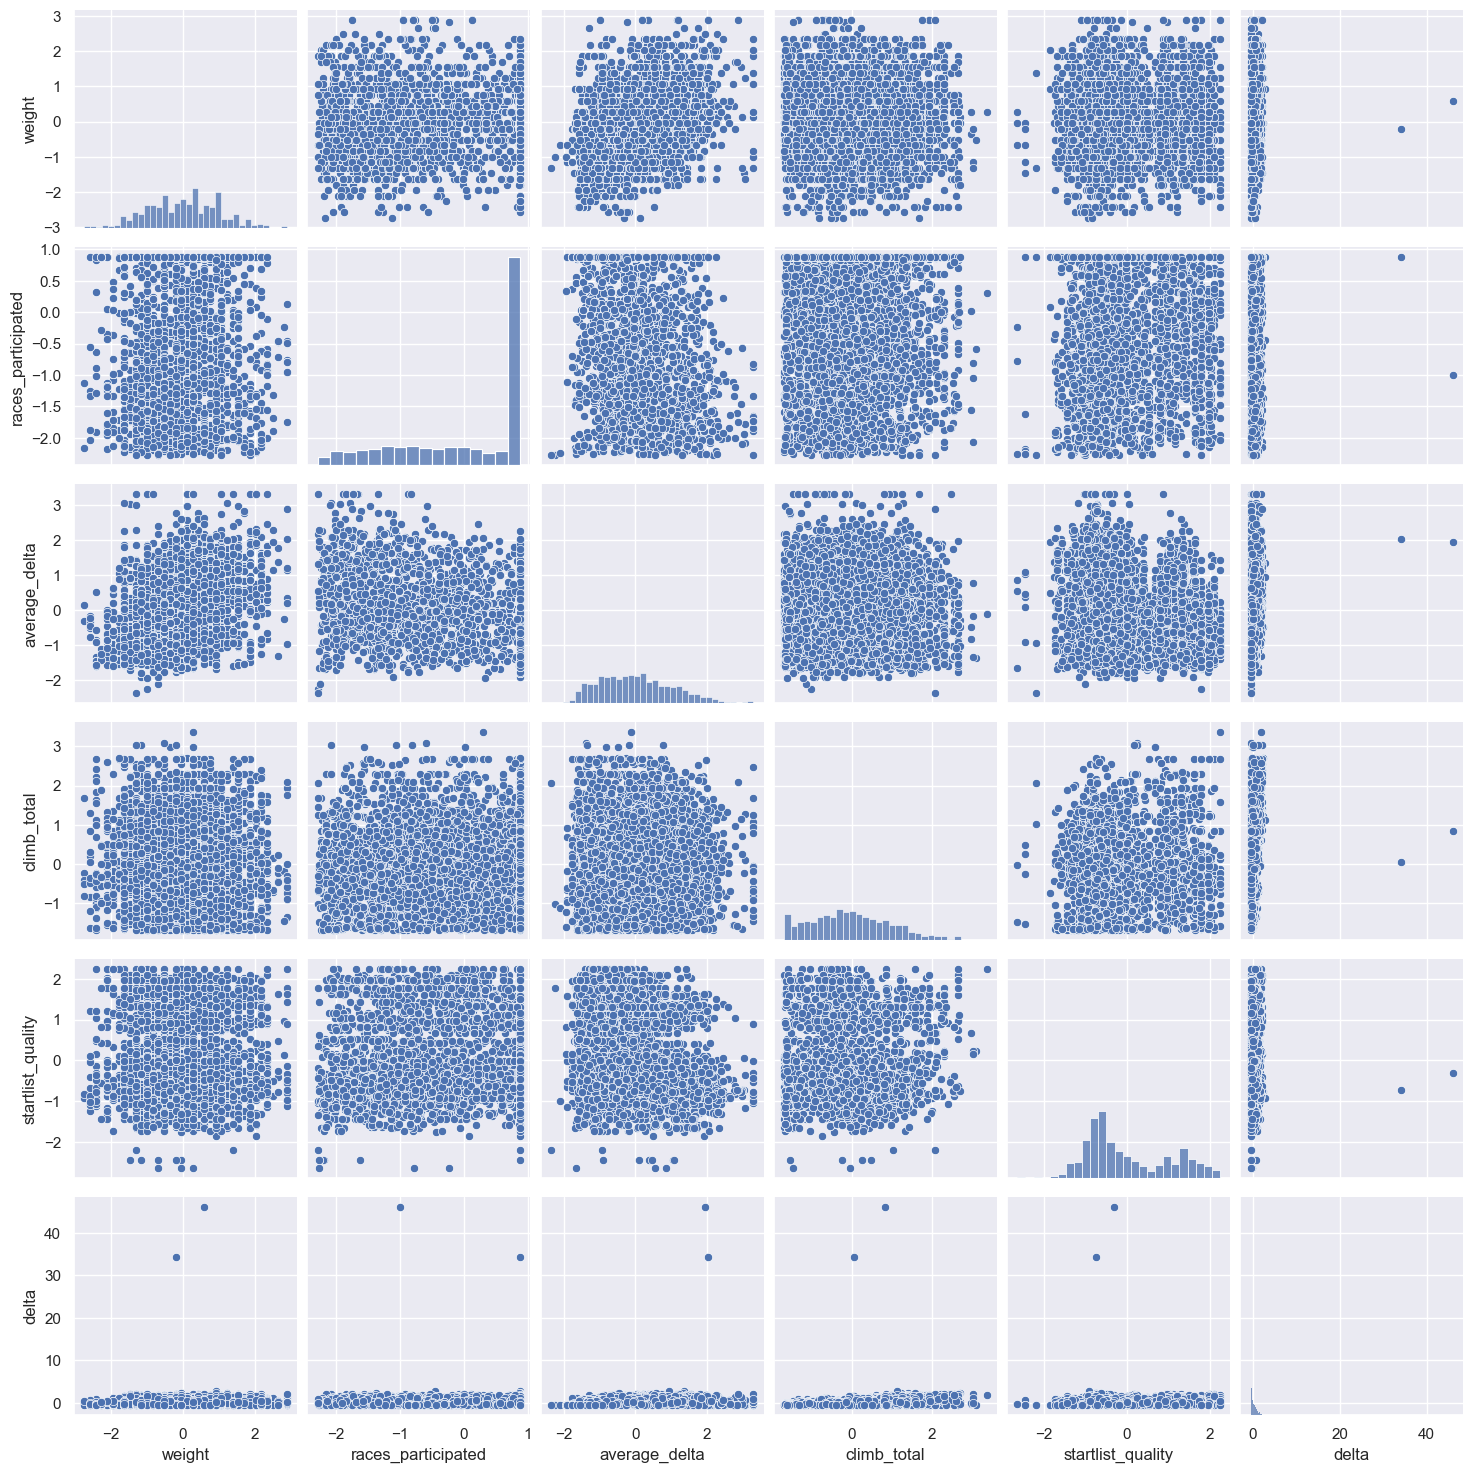

In [19]:
sns.pairplot(merged_scaled_df) # TODO: fare tutti i pairplot DOPO lo scaling?

# K-means Clustering


 
We'll use the Elbow Method and Silhouette Score to determine the optimal number of clusters.

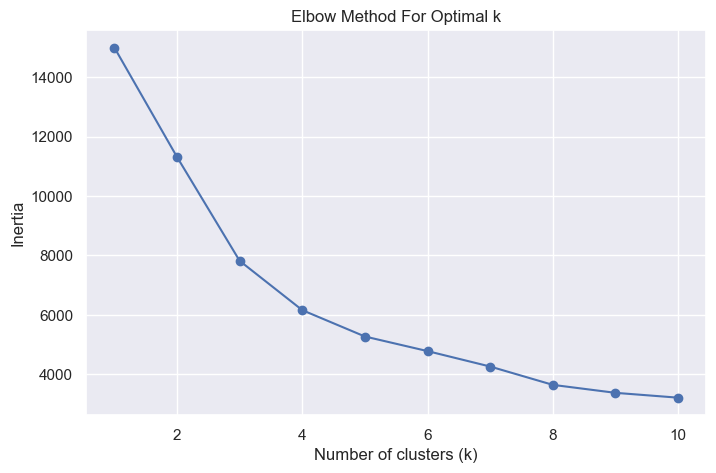

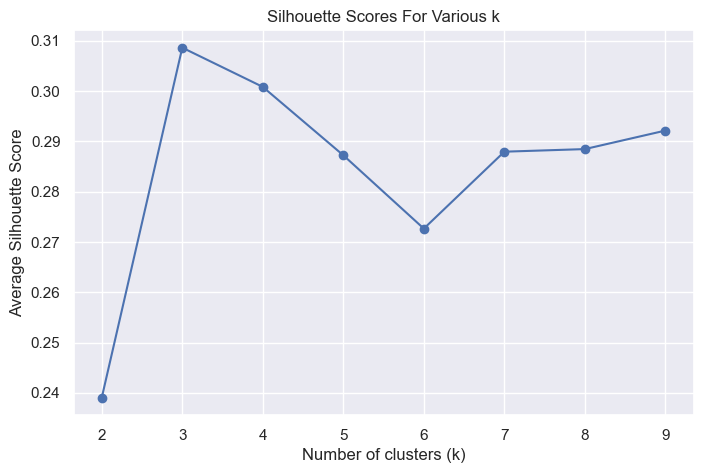

In [20]:
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# Define the range for K
K = range(1, 11)

# Elbow Method
inertia = []
for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(cyclists_scaled)
    inertia.append(kmeans.inertia_)

plt.figure(figsize=(8,5))
plt.plot(K, inertia, 'bo-')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Inertia')
plt.title('Elbow Method For Optimal k')
plt.show()

# Silhouette Scores
silhouette_avg = []
for k in range(2, 10):
    kmeans = KMeans(n_clusters=k, random_state=42)
    cluster_labels = kmeans.fit_predict(cyclists_scaled_df)
    silhouette_avg.append(silhouette_score(cyclists_scaled_df, cluster_labels))

plt.figure(figsize=(8,5))
plt.plot(range(2,10), silhouette_avg, 'bo-')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Average Silhouette Score')
plt.title('Silhouette Scores For Various k')
plt.show()


Based on these results, we'll choose k = ... TODO: decidere

In [21]:
# runnig kmeans with the chosen k
kmeans = KMeans(n_clusters=3, random_state=42)
cyclists_scaled_df['kmeans_cluster'] = kmeans.fit_predict(cyclists_scaled_df)
cyclists_scaled_df.head()

,weight,races_participated,average_delta,kmeans_cluster
0,1.852177,-0.182900,-0.063176,0
1,1.367906,2.253597,-0.201688,2
2,-0.892028,1.435123,-0.643197,2
3,-0.569181,2.253597,-0.262287,2
4,0.560787,2.253597,-0.729767,2


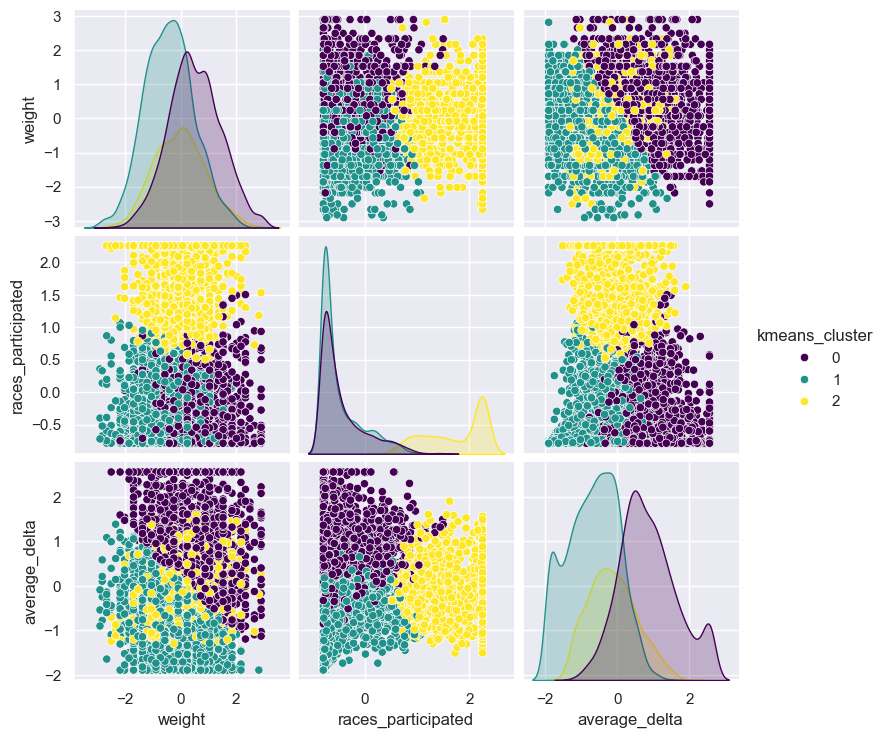

In [22]:
sns.pairplot(cyclists_scaled_df, hue='kmeans_cluster', palette='viridis')
plt.show()

Let's select some interesting plots to see them in more detail:

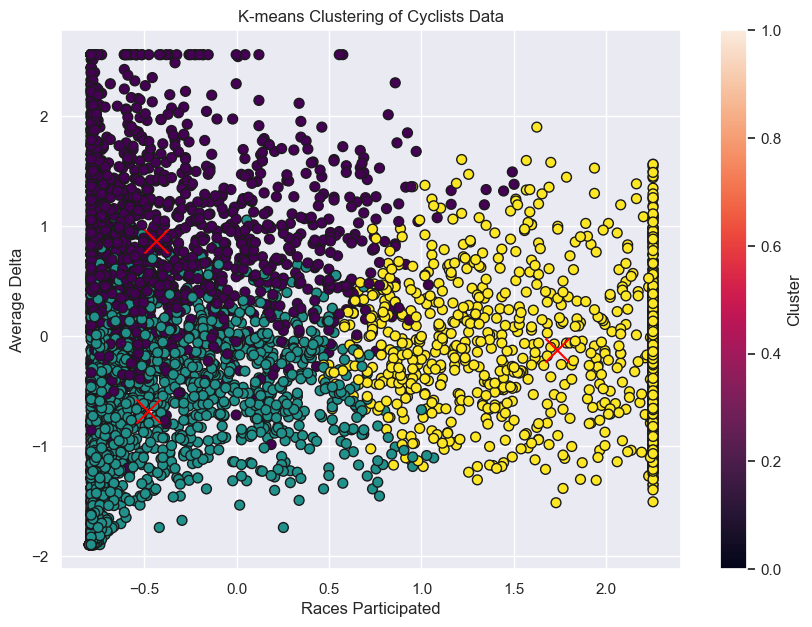

In [23]:
# Visualize the clusters
# TODO: estrarre in una funzione e usarla al posto di ripetere il codice
plt.figure(figsize=(10, 7))
plt.scatter(cyclists_scaled_df['races_participated'], cyclists_scaled_df['average_delta'], c=cyclists_scaled_df['kmeans_cluster'], cmap='viridis', marker='o', edgecolor='k', s=50)
plt.scatter(kmeans.cluster_centers_[:, cyclists_scaled_df.columns.get_loc('races_participated')], kmeans.cluster_centers_[:, cyclists_scaled_df.columns.get_loc('average_delta')], s=300, c='red', marker='x')  # Centroids
plt.title('K-means Clustering of Cyclists Data')
plt.xlabel('Races Participated')
plt.ylabel('Average Delta')
plt.colorbar(label='Cluster')
plt.show()

In [35]:
import plotly.express as px

# Create a 3D scatter plot
fig = px.scatter_3d(
    cyclists_scaled_df,
    x='races_participated',
    y='average_delta',
    z='weight',
    color='kmeans_cluster',
    title='3D Interactive Visualization of Clusters',
    labels={'races_participated': 'Races Participated', 'average_delta': 'Average Delta', 'weight': 'Weight'}
)

# Show the plot
fig.show()

In [25]:
kmeans_clusters = cyclists_scaled_df.groupby('kmeans_cluster').mean()
print("KMeans Cluster Profiles:")
kmeans_clusters

KMeans Cluster Profiles:


,weight,races_participated,average_delta
kmeans_cluster,,,
0,0.500219,-0.435575,0.866689
1,-0.412043,-0.481886,-0.678521
2,-0.033435,1.734515,-0.129725


In [26]:
# TODO: use PCA to reduce the dimensionality of the data and visualize it?

In [27]:
# TODO: fare lo stesso usando TSNE?

# DBSCAN Clustering

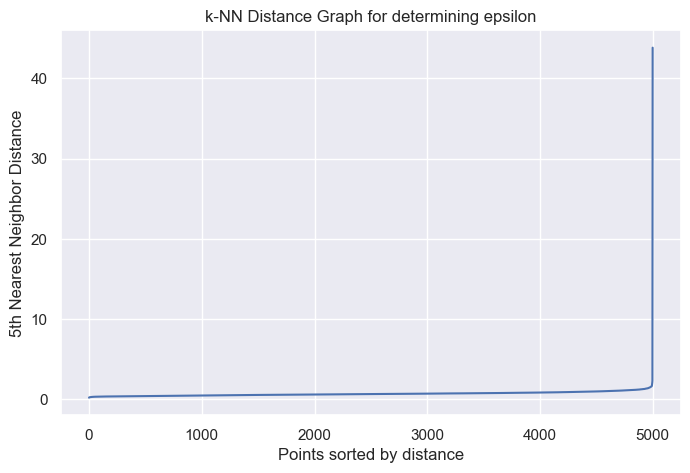

In [28]:
from sklearn.cluster import DBSCAN
from sklearn.neighbors import NearestNeighbors

# Determine optimal epsilon using k-distance graph
neighbors = NearestNeighbors(n_neighbors=5)
neighbors_fit = neighbors.fit(merged_scaled)
distances, indices = neighbors_fit.kneighbors(merged_scaled)

distances = np.sort(distances[:,4], axis=0)
plt.figure(figsize=(8,5))
plt.plot(distances)
plt.xlabel('Points sorted by distance')
plt.ylabel('5th Nearest Neighbor Distance')
plt.title('k-NN Distance Graph for determining epsilon')
plt.show()

Based on the k-distance graph, we'll choose `eps = ...`. TODO: decidere e aggiornare sotto

In [29]:
# Perform DBSCAN
dbscan = DBSCAN(eps=1.5, min_samples=5)
cyclists_features['dbscan_cluster'] = dbscan.fit_predict(cyclists_scaled)

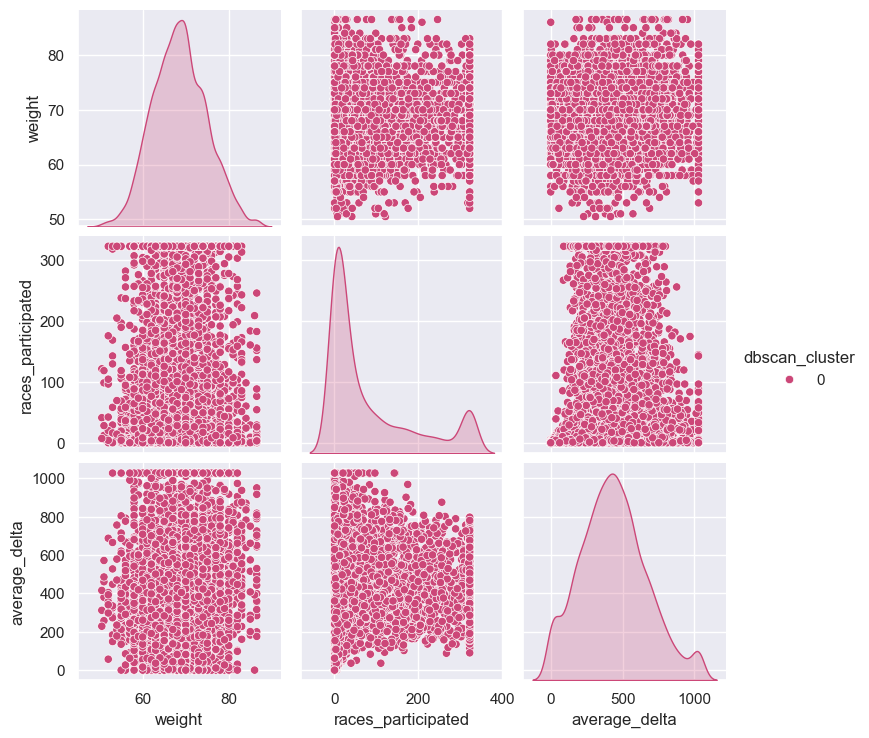

In [30]:
# Pairplot for DBSCAN clusters
sns.pairplot(cyclists_features, hue='dbscan_cluster', palette='plasma')

## Visualizations and analysis

# Hierarchical Clustering

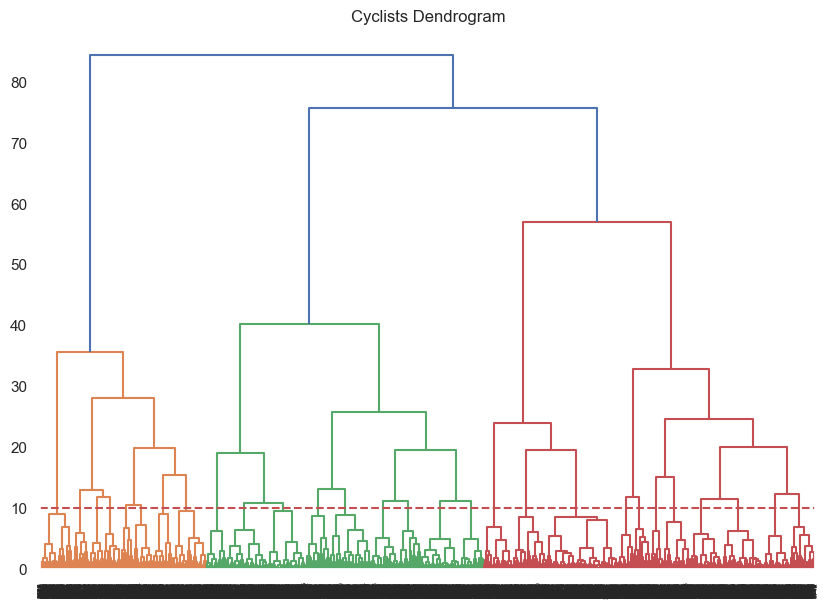

In [31]:
import scipy.cluster.hierarchy as shc

plt.figure(figsize=(10, 7))
plt.title("Cyclists Dendrogram")
dend = shc.dendrogram(shc.linkage(cyclists_scaled, method='ward'))
plt.axhline(y=10, color='r', linestyle='--') # TODO: scegliere il valore di cutoff
plt.show()

We'll cut the dendrogram at height = ... to get clusters. TODO: decidere e aggiornare TUTTO

In [32]:
from sklearn.cluster import AgglomerativeClustering

hierarchical = AgglomerativeClustering(n_clusters=3)
cyclists_features['hier_cluster'] = hierarchical.fit_predict(cyclists_scaled)

# Cluster Evaluation and Interpretation

# Final observations